# Digital House - Data Science a Distancia

## Trabajo Práctico 1

## Parte B: Limpieza de datos y generación de dataset final para modelado.

### Autores: Nahuel Bonfante, Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor

<p style="text-align:right;">Abril 2022</p>

#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


#### Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
data_url = "../Data/properatti.csv"
data = pd.read_csv(data_url, encoding="utf-8")

#### Eliminamos los valores nulos de la variable Target. 

In [3]:
#Limpiamos los NaN en el precio
data = data.dropna(axis=0, how='any', subset=['price_aprox_usd'])
data_clean = data

#### Eliminamos Outliers para las variables que vamos a correlacionar: 

In [4]:
#funcion para borrar outliers.
def borrar_outliers(data, columnas):
    u"""Solo recibe columnas con valores numericos. 
    Data: dataset a analizar
    Columnas: columnas donde borrar outliers.Deben ser una tupla"""
    cols_limpiar = columnas
    mask=np.ones(shape=(data.shape[0]), dtype=bool)

    for i in cols_limpiar:
        
        #calculamos cuartiles, y valores de corte
        Q1=data[i].quantile(0.25)
        Q3=data[i].quantile(0.75)
        RSI=Q3-Q1
        max_value=Q3+1.5*RSI
        min_value=Q1-1.5*RSI
        
        #ajusto el min value 
            # No puede ser negativo.
            # No puede estar fuera del boxplot para outliers
            # Criterio experto se decide dejar desde el 5% hacia adelante en el precio.
            # Además, no consideraremos los que tienen menos de 10m2.
            
        min_value=max(data[i].quantile(0.05), min_value, 10)
        
        #filtramos por max y min
        mask=np.logical_and(mask, np.logical_and(data[i]>=min_value, data[i]<=max_value))
    return data[mask]

In [5]:
#Hacemos las iteraciones para place y para tipo. Elegimos arbitrariamente cuanto quiero mostrar. 
#Eligimos los que tienen mas valores, y despues pasamos un index para que solo me muestre el nombre del lugar
iterar_place=data_clean['place_name'].value_counts().head(300)
iterar_place['otro_place']=0
iterar_place = iterar_place.index

iterar_tipo=data_clean['property_type'].value_counts().head(2)
#Esto esta comentado para NO CONTEMPLAR los otros tipos en el calculo
# iterar_tipo['otro_tipo']=0
iterar_tipo = iterar_tipo.index

In [6]:
#todos los valores que no entren en alguna de las categorias recien planteadas, son metidas en "OTROS"
#Modificamos data_clean, pero en nuevas columnas

data_clean['place_name'] = [x if x in iterar_place else 'otro_place' for x in data_clean['place_name']]
data_clean['property_type'] = [x if x in iterar_tipo else 'otro_tipo' for x in data_clean['property_type']]

---
#### Creacion de nuevas variables con valor predictivo:

#####  Creamos variables en funcion a la variable descripción:

Nos proponemos encontrar amenities interesantes como Pileta, Parrilla, Cochera. Estas categorías fueron elegidas arbitrariamente, para demostrar el metodo de scrapping. Pueden replantearse en un futuro.

In [7]:
def regex_to_tags(col, reg, match, not_match = np.NaN) :
    u"""Returns a series with 'match' values result of apply the regular expresion to the column
    the 'match' value will be when the regular expression search() method found a match
    the 'not_match' value will be when the regular expression serach() method did not found a match
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : match if x is not None else not_match)
   
    return serie

In [8]:
#Buscamos cocheras
_pattern = 'cochera|garage|auto'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['cochera'] = regex_to_tags(data_clean['description'], _express, 'si', 'no')


In [9]:
#Buscamos piletas
_pattern = 'piscina|pileta'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['pileta'] = regex_to_tags(data_clean['description'], _express, 'si', 'no')


In [10]:
#Buscamos Parrillas
_pattern = 'parrilla'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['parrilla'] = regex_to_tags(data_clean['description'], _express, 'si', 'no')


In [11]:
def regex_to_values_2(col, reg) :
    u"""Returns a serie with the result of apply the regular expresion to the column
    the serie have a float value only when regular expression search() method found a match
    
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : np.NaN if x is np.NaN or x is None else float(x.group(1)))

    return serie

---
### Generación de variables a imputar: relleno de valores nulos
#### Analisis para Cantidad de ambientes: 

##### Nos proponemos quitar de la descripción la cantidad de ambientes para llenar la variable rooms: 

In [12]:
#Buscamos cantidad de ambientes
_pattern = '([1-2][0-9]?)(?= amb)'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_values_2(data_clean['description'], _express)

data_clean['ambientes'] = work


In [13]:
#realizamos la imputacion
data_clean['ambientes_final'] = data_clean['rooms']
mask = data_clean['ambientes_final'].isnull() & data_clean['ambientes'].notnull()
data_clean.loc[mask, 'ambientes_final'] = data_clean.loc[mask, 'ambientes']

---
### Generación del dataset final.
#### Vamos a levantar nuevamente el data original. Generamos un dataset final en base al análisis de datos que realizmos 

In [14]:
# serie para determinar observaciones sin outliers para precio en dólares y superficie cubierta
data_clean['tidy1'] = np.NaN

for tipo in iterar_tipo:
    for place in iterar_place:
        # selecciono por lugar y tipo
        mask = np.logical_and(data_clean['place_name']==place, data_clean['property_type']==tipo)
        # calcula outliers y los suprime
        data_ok = borrar_outliers(data_clean[mask], ('price_aprox_usd', 'surface_covered_in_m2'))
        # determina observaciones válidas
        data_clean.loc[data_ok.index, 'tidy1'] = True

# probablemente esto se pueda hacer con algún método de pandas pero me resulta más simple pensarlo de este modo

In [15]:
# suprimo las observaciones que no me sirven
data_clean = data_clean.dropna(axis=0, how='any', subset=['tidy1'])

In [16]:
data_final = data_clean.drop(columns=['Unnamed: 0','operation', 'place_with_parent_names', 
                                      'country_name','geonames_id', 'lat-lon', 'lat', 'lon', 'price', 'currency',
                                        'price_aprox_local_currency','floor', 'surface_total_in_m2', 'price_usd_per_m2', 
                                     'price_per_m2', 'expenses', 'properati_url', 'description', 'title', 'image_thumbnail', 'tidy1'])

In [17]:
data_final

,property_type,place_name,state_name,price_aprox_usd,surface_covered_in_m2,rooms,cochera,pileta,parrilla,ambientes,ambientes_final
2,apartment,Mataderos,Capital Federal,72000.0,55.0,NaN,no,no,no,2.0,2.0
4,apartment,Centro,Buenos Aires Costa Atlántica,64000.0,35.0,NaN,no,no,no,NaN,NaN
7,apartment,Belgrano,Capital Federal,138000.0,40.0,NaN,no,si,no,NaN,NaN
8,apartment,Belgrano,Capital Federal,195000.0,60.0,NaN,no,si,no,NaN,NaN
13,apartment,Palermo Soho,Capital Federal,111700.0,30.0,1.0,no,si,no,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
121158,apartment,Recoleta,Capital Federal,165000.0,39.0,NaN,no,no,si,NaN,NaN
121216,house,Beccar,Bs.As. G.B.A. Zona Norte,498000.0,360.0,NaN,si,si,si,NaN,NaN
121217,apartment,Villa Urquiza,Capital Federal,131500.0,39.0,NaN,si,no,si,NaN,NaN
121218,apartment,Plaza Colón,Buenos Aires Costa Atlántica,95900.0,48.0,NaN,no,no,no,2.0,2.0


---
#### Sanity checks

In [18]:
data_final.isnull().sum()

property_type                0
place_name                   0
state_name                   0
price_aprox_usd              0
surface_covered_in_m2        0
rooms                    40195
cochera                      0
pileta                       0
parrilla                     0
ambientes                55708
ambientes_final          34669
dtype: int64

In [19]:
count_tabla_max=10
corr_surf_covered=[]
min_value_count=100

for tipo in iterar_tipo:
    count_tabla=0
    
    for place in iterar_place:
        
        data_place = data_final[data_final.place_name==place]
        data_tipo = data_place[data_place.property_type==tipo]
        
        #Formato para que sea legible (no aporta mucho al calculo)
        spaces= " "*(16-len(place))
        conteo= data_tipo.shape[0]

        
        #Esta es la importante
        correlacion_cruda= data_tipo[['price_aprox_usd', 'surface_covered_in_m2']].corr().iloc[0,1]
        correlacion = round(correlacion_cruda,2)
        
               
        #Para descartar valores extremos, no mostramos combinaciones con menos de x lugares (arbitrario)
        if conteo > min_value_count:
            corr_surf_covered.append(correlacion)
            #Mostrar resultado en forma de tabla. Los primeros valores nada mas
            if count_tabla<=count_tabla_max:
                print(f' Lugar: {place} {spaces} \t // Tipo: {tipo} \t \t //corr: {correlacion} \t // conteo: {conteo}')
                count_tabla+=1


 Lugar: Córdoba           	 // Tipo: apartment 	 	 //corr: 0.62 	 // conteo: 2447
 Lugar: Mar del Plata     	 // Tipo: apartment 	 	 //corr: 0.75 	 // conteo: 2547
 Lugar: Rosario           	 // Tipo: apartment 	 	 //corr: 0.77 	 // conteo: 2839
 Lugar: Tigre             	 // Tipo: apartment 	 	 //corr: 0.71 	 // conteo: 1035
 Lugar: Nordelta          	 // Tipo: apartment 	 	 //corr: 0.75 	 // conteo: 1529
 Lugar: Belgrano          	 // Tipo: apartment 	 	 //corr: 0.86 	 // conteo: 1866
 Lugar: Palermo           	 // Tipo: apartment 	 	 //corr: 0.82 	 // conteo: 1744
 Lugar: Caballito         	 // Tipo: apartment 	 	 //corr: 0.87 	 // conteo: 1570
 Lugar: Pilar             	 // Tipo: apartment 	 	 //corr: 0.5 	 // conteo: 628
 Lugar: La Plata          	 // Tipo: apartment 	 	 //corr: 0.74 	 // conteo: 776
 Lugar: Olivos            	 // Tipo: apartment 	 	 //corr: 0.7 	 // conteo: 792
 Lugar: Córdoba           	 // Tipo: house 	 	 //corr: 0.76 	 // conteo: 1215
 Lugar: Mar del Plata    

Text(0.5, 1.0, 'Correlacciones usando superficie cubierta. \n PROMEDIO: 0.73')

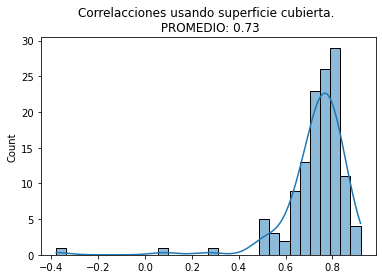

In [20]:
#graficamos las correlaciones obtenidas
sns.histplot(data=corr_surf_covered,  kde=True)
plt.title(f'Correlacciones usando superficie cubierta. \n PROMEDIO: {round(pd.Series(corr_surf_covered).mean(), 2)}')

In [21]:
data_final.shape

(67268, 11)

In [22]:
data_final[['price_aprox_usd', 'surface_covered_in_m2']].corr()

,price_aprox_usd,surface_covered_in_m2
price_aprox_usd,1.000000,0.686467
surface_covered_in_m2,0.686467,1.000000
